In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')
import time
%matplotlib inline

# Data: 28x28 grayscale images with 10 classes
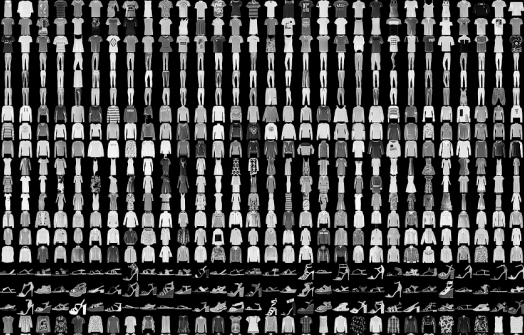

In [ ]:
df_train = pd.read_csv('./fashion-mnist_train.csv')
df_test = pd.read_csv('./fashion-mnist_test.csv')
ntrain = df_train.shape[0]
df = pd.concat([df_train, df_test])
print('train shape: {}, test shape: {}, total shape: {}'.format(df_train.shape, df_test.shape, df.shape))
print(df.shape)

In [ ]:
print('Null values? {}. Max value: {}. Min value: {}'.format(df.isnull().values.any(), df.max().max(), df.min().min()))

In [ ]:
from sklearn.model_selection import train_test_split

def one_hot_encode(y):
    oh = np.zeros(shape=(y.shape[0], len(np.unique(y))))
    oh[[np.arange(len(y)), y]] = 1
    return oh

X_train = df.drop('label', axis=1).values[:ntrain]/255.
y_train = df['label'].values[:ntrain]
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.05, shuffle=True, random_state=0)
y_train_oh = one_hot_encode(y_train)
y_valid_oh = one_hot_encode(y_valid)
X_test = df.drop('label', axis=1).values[ntrain:]/255.
y_test = df['label'].values[ntrain:]

#Some models use data in n_samples x n_features, some use n_features x n_samples
inverted = False

X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
def log_loss_logistic(y_pred, y):
    return (-y * np.log(y_pred) - (1 - y)*np.log(1 - y_pred)).mean()

def invert(boolean):
    global X_train, X_valid, X_test, y_train, y_train_oh, y_valid, y_valid_oh, y_test, inverted
    X_train = X_train.T
    X_valid = X_valid.T
    X_test = X_test.T

    y_train = y_train.T
    y_train_oh = y_train_oh.T
    y_valid = y_valid.T
    y_valid_oh = y_valid_oh.T
    y_test = y_test.T
    
    inverted = boolean
    
def softmax(z):
    return np.exp(z)/np.sum(np.exp(z))

# Logistic Regression (one vs all)
Cost Function: 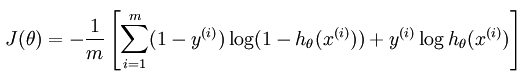

In [ ]:
lr = 0.5

if inverted:
    invert(False)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def lr_train(iterations=500):
    classes = np.unique(y_train)
    models = {}

    start = time.time()
    for class_n in classes:
        y_train_bin = np.array([1 if i==class_n else 0 for i in y_train], dtype=float)
        y_valid_bin = np.array([1 if i==class_n else 0 for i in y_valid], dtype=float)
        w = np.random.normal(loc=0, scale=0.5, size=X_train.shape[1])
        for i in range(1,1000):
            y_pred_train = sigmoid(np.dot(X_train, w))

            y_pred_valid = sigmoid(np.dot(X_valid, w))
            
            error_valid = log_loss_logistic(y_pred_valid, y_valid_bin)

            grad = np.dot(X_train.T, (y_pred_train - y_train_bin))/y_train_bin.size

            w = w - lr * grad

            if (i%50 == 0):
                print('Model: {}, iteration: {}, error_valid: {}'.format(class_n, i, error_valid))

        print('Model {} finished'.format(class_n))
        models[str(class_n)] = w
    total_time = time.time() - start

    return models, total_time

def lr_predict(models):
    pred = np.zeros((X_test.shape[0], len(models)))
    for class_n, class_w in models.items():
        pred[:, int(class_n)] = sigmoid(np.dot(X_test, class_w))
    
    class_pred = np.argmax(pred, axis=1)
    accuracy = np.sum(class_pred == y_test)/len(y_test)
    print('LR accuracy: {}'.format(accuracy))

In [ ]:
models_lr, time_lr = lr_train()
print(time_lr)
np.save('./models_lr', models_lr)

In [ ]:
lr_predict(models_lr)

# Multinomial Logistic Regression (Softmax Regression)

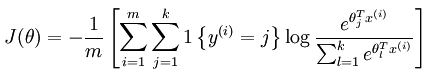

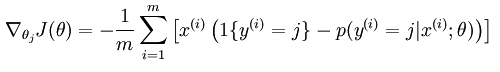

In [ ]:
lr = 0.2

if inverted:
    invert(False)

def mlr_train(iterations=1000):
    w = np.random.normal(loc=0, scale=0.5, size=(X_train.shape[1], len(np.unique(y_train)))) # m (features) x K (classes) 
    
    start = time.time()
    m = len(y_train)
    for i in range(iterations):
        y_pred_train = np.array([softmax(i) for i in np.dot(X_train, w)]) #m x K
        
        y_pred_valid = np.array([softmax(i) for i in np.dot(X_valid, w)]) #m x K
        
        error_valid = (-1 / X_valid.shape[0]) * np.sum(y_valid_oh * np.log(y_pred_valid))
        
        grad = (-1 / m) * np.dot(X_train.T,(y_train_oh - y_pred_train))
        
        w = w - lr * grad
        
        if (i%5 == 0):
            print('Mlr iteration: {}, validation log loss: {}'.format(i, error_valid))

    end = time.time()
    print('Finished, time elapsed: {}s'.format(end - start))

    return w, end - start

def mlr_predict(w):
    pred = np.array([softmax(i) for i in np.dot(X_test, w)])
    class_pred = np.argmax(pred, axis=1)
    
    accuracy = np.sum(class_pred == y_test)/len(y_test)
    print('MLR accuracy: {}'.format(accuracy))

In [ ]:
w_mlr, time_mlr = mlr_train()
# np.save('./w_mlr', w_mlr)

In [ ]:
mlr_predict(w_mlr)

# Neural Network - 1 hidden layer

In [ ]:
iterations = 1000
lr = 0.3
activation_type='relu'

if not inverted:
    invert(True)

N1 = X_train.shape[0] #784
N2 = 50
N3 = y_train_oh.shape[0] #10

shapes = {
    1: (N2, N1),
    2: (N3, N2),
}

def activation(z):
    if (activation_type == 'sigmoid'):
        return 1 / (1 + np.exp(-z))
    if (activation_type == 'relu'):
        return z * (z > 0)
    if (activation_type == 'linear'):
        return z

def derivative(z):
    if (activation_type == 'sigmoid'):
        return activation(z)*(1-activation(z))
    if (activation_type == 'relu'):
        return 1. * (z > 0)
    if (activation_type == 'linear'):
        return 1

m = X_train.shape[1]
start = time.time()
theta1 = np.random.normal(loc=0, scale=0.5, size=shapes[1])
theta2 = np.random.normal(loc=0, scale=0.5, size=shapes[2])
for it in range(iterations):
    
    #forward train
    a1 = X_train #N1 x m
    z2 = np.dot(theta1, a1) #N2 x N1 . N1 x m
    a2 = activation(z2) #N2 x m
    z3 = np.dot(theta2, a2) #N3 x N2 . N2 x m
    a3 = np.apply_along_axis(softmax, 0, z3) #N2 x m
    
    #forward valid
    v_a1 = X_valid #N1 x m
    v_z2 = np.dot(theta1, v_a1) #N2 x N1 . N1 x m
    v_a2 = activation(v_z2) #N2 x m
    v_z3 = np.dot(theta2, v_a2) #N3 x N2 . N2 x m
    v_a3 = np.apply_along_axis(softmax, 0, v_z3) #N3 x m
    
    error_valid = (-1 / X_valid.shape[1]) * np.sum(y_valid_oh * np.log(v_a3))

    #backward
    d3 = a3 - y_train_oh
    d2 = np.multiply(np.dot(theta2.T, d3), derivative(z2))

    delta1 = np.dot(d2, a1.T)
    delta2 = np.dot(d3, a2.T)
    
    #update
    theta1 -= lr*delta1/m
    theta2 -= lr*delta2/m
    
    if (it%5 == 0):
#         lr = lr*0.99
        print('NN iteration: {}, validation log loss: {}'.format(it, error_valid))
print('Time elapsed: {}'.format(time.time() - start))

In [ ]:
# forward on test set
a1 = X_test
z2 = np.dot(theta1, a1)
a2 = activation(z2)
z3 = np.dot(theta2, a2)
a3 = np.apply_along_axis(softmax, 0, z3) 

# get accuracy on test set
class_pred = np.argmax(a3, axis=0)

accuracy = np.sum(class_pred == y_test)/len(y_test)
print('NN accuracy: {}'.format(accuracy))

# Neural Network - 2 hidden layers

In [ ]:
iterations = 1000
lr = 0.3
activation_type='tanh'

if not inverted:
    invert(True)

N1 = X_train.shape[0] #784
N2 = 30
N3 = 30
N4 = y_train_oh.shape[0] #10

shapes = {
    1: (N2, N1),
    2: (N3, N2),
    3: (N4, N3)
}

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

beta = 1 #used on swish activation function

def activation(z):
    if (activation_type == 'sigmoid'):
        return sigmoid(z)
    if (activation_type == 'relu'):
        return z * (z > 0)
    if (activation_type == 'linear'):
        return z
    if (activation_type == 'swish'):
        return z*sigmoid(beta*z)
    if (activation_type == 'tanh'):
        return np.tanh(z)

def derivative(z):
    if (activation_type == 'sigmoid'):
        return activation(z)*(1-activation(z))
    if (activation_type == 'relu'):
        return 1. * (z > 0)
    if (activation_type == 'linear'):
        return 1
    if (activation_type == 'swish'):
        return beta*activation(z) + sigmoid(beta*z)*(1 - beta*activation(z))
    if (activation_type == 'tanh'):
        return 1 - np.tanh(z)**2

m = X_train.shape[1]
start = time.time()
theta1 = np.random.normal(loc=0, scale=0.5, size=shapes[1])
theta2 = np.random.normal(loc=0, scale=0.5, size=shapes[2])
theta3 = np.random.normal(loc=0, scale=0.5, size=shapes[3])
for it in range(iterations):

    #forward train
    a1 = X_train
    z2 = np.dot(theta1, a1)
    a2 = activation(z2)
    z3 = np.dot(theta2, a2)
    a3 = activation(z3)
    z4 = np.dot(theta3, a3)
    a4 = np.apply_along_axis(softmax, 0, z4)

    #forward valid
    v_a1 = X_valid
    v_z2 = np.dot(theta1, v_a1)
    v_a2 = activation(v_z2)
    v_z3 = np.dot(theta2, v_a2)
    v_a3 = activation(v_z3)
    v_z4 = np.dot(theta3, v_a3)
    v_a4 = np.apply_along_axis(softmax, 0, v_z4)
  
    error_valid = (-1 / X_valid.shape[1]) * np.sum(y_valid_oh * np.log(v_a4))

    #backward
    d4 = a4 - y_train_oh
    d3 = np.multiply(np.dot(theta3.T, d4), derivative(z3))
    d2 = np.multiply(np.dot(theta2.T, d3), derivative(z2))

    delta1 = np.dot(d2, a1.T)
    delta2 = np.dot(d3, a2.T)
    delta3 = np.dot(d4, a3.T)

    #update
    theta1 -= lr*delta1/m
    theta2 -= lr*delta2/m
    theta3 -= lr*delta3/m
    
    if (it%5 == 0):
        lr = lr*0.99
        print('NN iteration: {}, validation log loss: {}'.format(it, error_valid))
        
print('Time elapsed: {}'.format(time.time() - start))

In [ ]:
# forward on test set
a1 = X_test
z2 = np.dot(theta1, a1)
a2 = activation(z2)
z3 = np.dot(theta2, a2)
a3 = activation(z3)
z4 = np.dot(theta3, a3)
a4 = np.apply_along_axis(softmax, 0, z4)

# get accuracy on test set
class_pred = np.argmax(a4, axis=0)

accuracy = np.sum(class_pred == y_test)/len(y_test)
print('NN accuracy: {}'.format(accuracy))

# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
a3 = np.load('a3_nn1relu30.npy')
class_pred = np.argmax(a3, axis=0)

cm = confusion_matrix(y_test, class_pred)

In [ ]:
df_cm = pd.DataFrame(cm, index = [i for i in range(len(cm))],
                  columns = [i for i in range(len(cm))])
plt.figure(figsize = (10,7))

ax = plt.axes()
sns.heatmap(df_cm, annot=True, fmt='g', ax = ax)

ax.set_title('Matriz de Confusão')
ax.set_ylabel('Classe Real')
ax.set_xlabel('Classe Prevista')